711.2185530646049 Particle is Geldart B type
[-9.41731076e-05 -9.65687250e-05 -9.75794292e-05 -9.64126166e-05
 -9.30371301e-05 -8.74790939e-05 -7.98123567e-05 -7.01596592e-05
 -5.86913811e-05  1.35302982e+00] [-2.81862484e-04 -2.84440202e-04 -2.82109409e-04 -2.73349641e-04
 -2.58196204e-04 -2.36844257e-04 -2.09628916e-04 -1.77024651e-04
 -1.39638690e-04  1.33214768e+00] [-5.86212589e-06 -5.90320650e-06 -5.80125945e-06 -5.55890459e-06
 -5.18027877e-06 -4.67138057e-06 -4.04080929e-06 -3.29995892e-06
 -2.46293990e-06  1.32277919e-02] [-1.17242485e-05 -1.17435661e-05 -1.15128625e-05 -1.10098684e-05
 -1.02409166e-05 -9.21761642e-06 -7.95712244e-06 -6.48221617e-06
 -4.82103793e-06  2.39015275e-02] [-6.80006345e-04 -6.78340257e-04 -6.63475164e-04 -6.33245605e-04
 -5.87959470e-04 -5.28289658e-04 -4.55241690e-04 -3.70145323e-04
 -2.74633791e-04  1.33515021e+00]


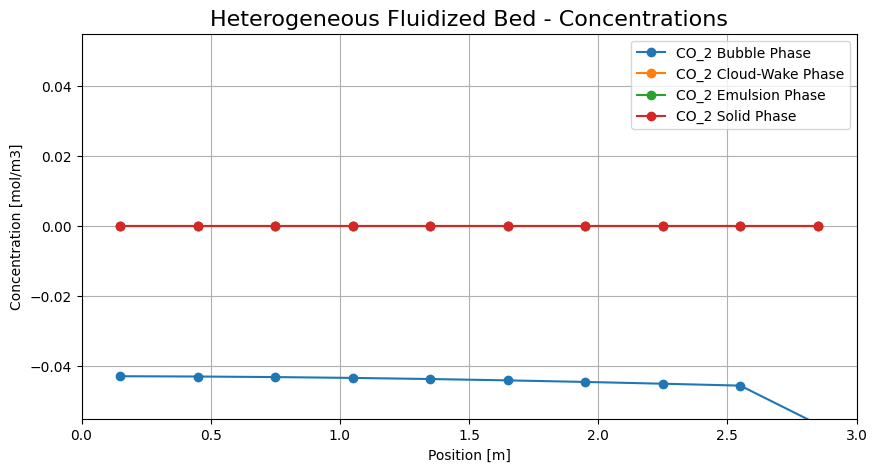

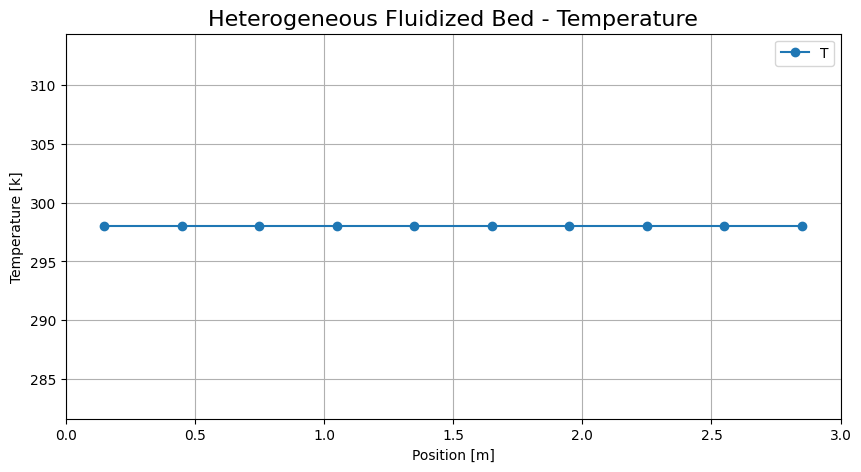

In [23]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.sparse as sps 
import pymrm  as mrm
import math
from FluidizationHydrodynamics import *

# Heterogeneous particle model for adsorption
class AdsorptionReactorModel:
    def __init__(self, Tin, d_p, u_0):
        #Simulation parameters
        self.Nz = 10
        self.Nc = 10 # 4 components and 1 temperatures for each solid and gas phase
        self.Tin = 298
        
        # Fluidization Hydrodynamics
        model = FluidizationHydrodynamics()
        model.init(d_p,u_0,self.Nz)
        self.z = model.z
        self.eps_mf = model.epsilon_mf

        # Phase fractions as arrays of length of nz
        self.fc= model.fc
        self.fb = model.fb
        self.fw = model.fw
        self.fe = model.femulsion

        self.ub = model.u_b
        self.ub_second_option = model.u_b_1
        self.ue = model.u_emulsion
        self.us = model.us_down
        self.kgs = model.kgs
        self.kbc_ce = model.kgas
        self.db = model.d_b

        self.gamma_b = 0.005
        self.gamma_cw = 0.01

        """ DEFINED MULTIPLE TIMES"""
        self.eps_mf = 0.42
        self.gamma_e = 1 - self.eps_mf

        self.Lr = model.Lr # Reactor length already defined in fluidization hydrodynamics
        self.Tin = Tin
        self.P = 1*101325 

        ## Gas constants
        self.Rho_g = 1  #Density of the gas
        self.eta_g = 4e-5 #Viscosity gas 
        self.Cp_g = 5e3 #Heat capacity gas
        self.lam_g = 0.03 #Thermal diffusivity
        self.Rg = 8.314  #Gas constant

         # For the Lewatit VP OC 1065 adsorbent particle
        self.lam_s = 70 # Thermal diffusivity NEEDED
        self.rho_s = 744 # Solid density
        self.d_p = d_p # Diameter of the particle 
        self.Cp_s = ((-3.23e4)/(self.Tin**2) + (0.00227)*(self.Tin) - (-0.994))*(10**3) # Heat capacity 
        self.Dax_s = 0.0
        self.eps_b = 0.4 # Packing in the bed at minimum fluidization -> should be epsilon_mf from FluidizationHydrodynamics
        self.eps_s = 0.338 # Porosity of the Lewatit particle
        self.tauw = np.sqrt(2)
        self.d_pore = 25e-9 # Average pore diameter of the Lewatit particle 

        self.lam_g = 0.03 # Thermal conductivity of air [W/m/K]
        self.R_gas = 8.314 # Gas constant [J/mol/K]

        self.lam_s = 73 # Thermal conductivity of Lewatit [W/m/K] REQUIRED FOR PARTICLE MODEL

        self.A = self.lam_s/self.lam_g 
        self.B = 1.25*((1-self.eps_b)/self.eps_b)**(10/9)
        self.gamma = 2/(1-self.B/self.A)*((self.A-1)/(1-self.B/self.A)**2*self.B/self.A*(np.log(self.A/self.B))-0.5*(self.B+1))

        #  Check how the static thermal diffusion is considered
        self.lam_stat = self.lam_g*((1-np.sqrt(1-self.eps_b))+np.sqrt(1-self.eps_b)*self.gamma)
        
        self.Df_Thermal = self.lam_g/(self.Rho_g*self.Cp_g) # Thermal diffusivity of air [m2/s]
        self.Ds_Thermal = self.lam_s/(self.rho_s*self.Cp_s) # Thermal diffusivity of the particle [m2/s]

        #Heat of reaction
        self.H_r = -81e3 # Heat ofadsorption in J/mol  
        
        #  Miscellaneous
        self.lam_s = 70 
        self.u_g = 0.5 # Check if this is superficial gas velocity and how this should be changed for the different B/CW/E
        self.vel = 1 # np.concatenate([np.full(self.Nc,self.u_g),np.zeros(self.Nc)])
        self.Lr = 3 # Length of the reactor dp/2  # Radius of the particle
        self.dt = 0.01 #np.inf  # Time step (infinity for steady state)
        self.dz = self.Lr/self.Nz
        self.dr_large = 0.3  # Initial large grid spacing
        self.refinement_factor = 0.75  # Factor for refining the grid
        self.Co = self.ub_second_option/(self.dz/self.dt) # Courant number for stability
        self.z_f = mrm.non_uniform_grid(0, self.Lr, self.Nz + 1, self.dr_large, self.refinement_factor)
        self.z_c = 0.5 * (self.z_f[:-1] + self.z_f[1:])

        self.P = 1*101325 
        self.X_CO2 = 0.04 #The actual figure is 0.0004
        self.X_O2 = 0.2095
        self.X_Ar = 0.0093 
        self.X_N2 = 1 - self.X_CO2 - self.X_O2 #- self.X_Ar

        self.Cin_N2 = (self.P*0.5)/(self.Rg*self.Tin) # self.P*self.X_N2/(self.Rg*self.Tin)
        self.Cin_CO2 = (self.P*0.5)/(self.Rg*self.Tin) # The actual value is self.P*self.X_CO2/(self.Rg*self.Tin)

        ## Maxwell-Stefan constants
        #Molecular weights 
        self.M_CO2 = 44  # 1 
        self.M_N2 = 2    # 2
        self.M_O2 = 32  # 3
        self.M_Ar = 39.95  # 4

        #Diffusion volumes
        self.V_CO2 = 26.7 
        self.V_N2 = 6.12
        self.V_O2 = 16.3 
        self.V_Ar = 16.2

        self.Dm_CO2, self.Dm_N2, self.Dm_O2, self.Dm_Ar = self.calculate_average_diffusion_coefficients(self.Tin, self.P)
        
        self.c0 = np.array([0,0,0,0, self.Tin,0,0,0,0, self.Tin], dtype='float')
        self.c_in = np.array([self.Cin_CO2,0 , 0, 0,  self.Tin, self.Cin_N2, 0, 0, 0,  self.Tin], dtype='float')
    
        # The following values are still required
        self.D_ax_g = 0
        self.D_ax_s = 0 # This one is estimated from the FluidizationHydrodynamics
        self.Dax_Thermal = 0

        self.Dax = np.array([self.D_ax_g, self.D_ax_g, self.D_ax_g, self.D_ax_s, self.Dax_Thermal,self.D_ax_g, self.D_ax_g, self.D_ax_g, self.D_ax_s, self.Dax_Thermal], dtype = 'float')
        self.vel = 0.02
        
        # self.bc_ax = {
        #             'a': [[[self.Dax]], 1], 
        #             'b': [[[self.vel]], 0], # Neumann boundary conditions
        #             'd': [[[self.vel*self.c_in]] , 0.0], # Values
        #              }

        self.bc_ax = {'a':[1,0],'b':[0,1], 'd':[0.0, [self.c_in]]}

        self.init_field(self.c0)

        self.init_Jac()

        self.freq_out=100

    def fuller(self, T, M1, M2, V1, V2, P):
        D_ij = 1.013e-2 * T**1.75 / P * np.sqrt(1/M1 + 1/M2) / (V1**(1/3) + V2**(1/3))**2
        return D_ij
    

    def calculate_average_diffusion_coefficients(self, T, P):
        # Define the molecules and their properties
        molecules = [
            ('CO2', self.M_CO2, self.V_CO2),
            ('N2', self.M_N2, self.V_N2),
            ('O2', self.M_O2, self.V_O2),
            ('Ar', self.M_Ar, self.V_Ar)
        ]
        
        # Calculate diffusion coefficients for each molecule with every other molecule
        diffusion_coeffs = {mol[0]: [] for mol in molecules}
        
        for i, (name1, M1, V1) in enumerate(molecules):
            for j, (name2, M2, V2) in enumerate(molecules):
                if i != j:
                    diffusion_coeff = self.fuller(T, M1, M2, V1, V2, P)*self.eps_s/self.tauw
                    diffusion_coeffs[name1].append(diffusion_coeff)
        
        # Calculate average diffusion coefficient for each molecule
        avg_diffusion_coeffs = {name: np.mean(coeffs) for name, coeffs in diffusion_coeffs.items()}
        #print(f"Average Diffusion Coefficients: {avg_diffusion_coeffs}")
        
        return avg_diffusion_coeffs['CO2'], avg_diffusion_coeffs['N2'], avg_diffusion_coeffs['O2'], avg_diffusion_coeffs['Ar']


    def init_field(self, c0):
        self.c = np.full([self.Nz, self.Nc], c0, dtype='float')

    ## Reaction rate equations
    def reaction(self, c):
        u_b = self.ub
        u_b_2 = self.ub_second_option
        u_e = self.ue
        k_gs = self.kgs 
        kbc_ce = self.kbc_ce
        d_b = self.db

        T_p_gas = c[:,4]
        T_p_solid = c[:,9]

        # CO2 and N2 are the 2 adsorbed species so the pressures are based on the solid phase concentration
        pCO2 = c[:,4]*self.Rg*T_p_gas
        pN2 = c[:,8]*self.Rg*T_p_gas

        # pO2 = c[:,2]*self.Rg*T_p_gas
        # pAr = c[:,3]*self.Rg*T_p_gas
 
        # Mass transfer coefficients obtained from the Gunn correlation
        kCO2 = k_gs[0]
        kN2 = k_gs[1]

        # Bubble to cloud mass transfer coefficients
        k_bc_CO2 = kbc_ce[0,:,0]
        k_ce_CO2 = kbc_ce[1,:,0]

        # Cloud to emulsion mass transfer coefficients
        k_bc_N2 = kbc_ce[0,:,1]
        k_ce_N2 = kbc_ce[1,:,1]

        """ THESE VALUES ARE ARBITRARY """
        # Specific surface areas per unit of reactor volume
        d_b = 0.01 # Set to 10 cm just as an initial approximation
        f_b = 0.2 # Fraction of bubble per m3 of reactor
        a_bubble = (6/d_b)*(f_b)
        
        d_p =  300e-6 # The diameter of the particle model
        f_s =  0.1 # Fraction of solids per m3 of reactor volume - ARBITRARY VALUE (gamma_b + gamma_cw + gamma_e)*(f_b)
        a_solid = (6/d_p)*(f_s)

        # BETarea = 31*self.rho_s*1000 # (m2/g of catalyst)(kg/m3 catalyst)

        # Bubble diameter and specific area
        # Carbon Dioxide
        self.mtCO2b_cw = k_bc_CO2*(a_bubble)*(c[:,1] - c[:,0])
        self.mtCO2cw_e = k_ce_CO2*(a_solid)*(c[:,2] - c[:,1])
    
        self.mtCO2s_b = kCO2*(6/d_p)*(self.gamma_b)*(self.fb)*(c[:,3] - c[:,0])
        self.mtCO2s_cw = kCO2*(6/d_p)*(self.gamma_cw)*(self.fb)*(c[:,3] - c[:,1])
        self.mtCO2s_e = kCO2*(6/d_p)*(self.gamma_e)*(self.fb)*(c[:,3] - c[:,2])

        # Nitrogen
        self.mtN2b_cw = k_bc_N2*(a_bubble)*(c[:,6] - c[:,5])
        self.mtN2cw_e = k_ce_N2*(a_solid)*(c[:,7] - c[:,6])

        self.mtN2s_b = kN2*(6/d_p)*(self.gamma_b)*(self.fb)*(c[:,8] - c[:,5])
        self.mtN2s_cw = kN2*(6/d_p)*(self.gamma_cw)*(self.fb)*(c[:,8] - c[:,6])
        self.mtN2s_e = kN2*(6/d_p)*(self.gamma_e)*(self.fb)*(c[:,8] - c[:,7])

        # kheat = Nu*self.d_p/self.Df_Thermal
        # ht = kheat*(6/self.d_p)*(self.eps_s)*(c[:,4] - c[:,9])

        f = np.zeros_like(c)
        
        # # Validation case
        # # -H2O - H2 - CO2 - CO -CH4 for 3 PHASES -> 15 balances
        # pCH4 = self.R_gas*self.Tin*self.c[:,0]
        # pH2O = self.R_gas*self.Tin*self.c[:,1]
        # pH2 = self.R_gas*self.Tin*self.c[:,2]
        # pCO = self.R_gas*self.Tin*self.c[:,3]
        # pCO2 = self.R_gas*self.Tin*self.c[:,4]

        # # Steam-Methane Reforming
        # self.deltaG_SMR = 1
        # Keq_SMR = np.exp(self.deltaG_SMR/(self.R_gas*self.Tin))
        # A1 = 2.45e2 # Preexponential factor
        # Eact_1 = 106.9e3 # Activation Energy (J/mol)
        # k1 = A1*np.exp((-Eact_1)/(self.R_gas*self.Tin))
        # SMR_kinetics = k1*(pCH4*pH2O - (pH2**3)*(pCO/Keq_SMR))/(pH2O**(1.596))
        # r1 = SMR_kinetics*self.rho_s*1e3 # /101325

        # # Water-Gas Shift
        # self.deltaG_WGS = 1
        # Keq_WGS = np.exp(self.deltaG_WGS/(self.R_gas*self.Tin))
        # A2 = 2.62e5 # Preexponential factor
        # Eact_2 = 54.5e3 # Activation Energy (J/mol)
        # k2 = A2*np.exp((-Eact_2)/(self.R*self.Tin))
        # WGS_kinetics = k2*(pCO*pH2O - (pH2)*(pCO2/Keq_WGS))/(pH2O)
        # r1 = SMR_kinetics*self.rho_s*1e3 #/101325

        # r[np.isnan(r)]=0

        Ea = 0.6e3 # J/mol
        deltaH = 105.5e3 # J/mol
        deltaHc = 13.5e3 # J/mol
        b0 = 1.05e-13 # CHECK ORDER OF MAGNITUDE Unit is Pascal
        b0c = 1.03/10 # CHECK ORDER OF MAGNITUDE Unit is Pascal
        Rg = 8.31
        T0 = 298

        pCO2 =  self.R_gas*self.Tin*self.c[:,4] # Pressure in Pascal

        T = self.Tin
        q_inf0_constant = 2.56 # mmol/g
        q_infc_constant = 1.05 # mmol/g 

        b = b0*np.exp(deltaH/(Rg*T))
        bc = b0c*np.exp(deltaH/(Rg*T))

        tau0 = 0.343
        alpha = 1.39
        tau = tau0 + alpha*(1 - T0/T)
        
        chi = 1.63
        q_inf_0 = q_inf0_constant*np.exp(chi*(1 - (T/T0)))
        q_inf_c = q_infc_constant*np.exp(chi*(1 - (T/T0)))

        nphys = (q_inf_0*b*pCO2)/((1 + ((b*pCO2)**(tau)))**(1/tau))
        nchem = (q_inf_c*bc*pCO2)/(1 + bc*pCO2)
        eta = np.exp(-Ea/Rg*T)

        # print(tau,q_infc_constant,q_inf0_constant,b,bc)  
        # print(nphys,nchem,eta)

        q_equillibrium = nphys + nchem*eta
        
        self.r_p = self.d_p/2 # Particle radius
        self.r_c = self.d_pore/2 # Pore radius

        self.q0 = 2.56e-3 # Equillibrium surface concentration of the adsorbent particle (mol/g)
        self.k_f_CO2 = kCO2
        self.k_f_N2 = kN2
        self.c0 = pCO2/(self.R_gas*self.Tin)
        self.eps_p = self.eps_s

        self.Dknudsen_CO2 = (self.d_pore)*np.sqrt((8*self.R_gas*self.Tin)/(np.pi*self.M_CO2))
        self.DpCO2 = self.tauw*((1/self.Dm_CO2)+(1/self.Dknudsen_CO2))
        self.DmuCO2 = 1e5 # Micropore diffusion is currently neglected

        self.Dknudsen_N2 = (self.d_pore)*np.sqrt((8*self.R_gas*self.Tin)/(np.pi*self.M_CO2))
        self.DpN2 = self.tauw*((1/self.Dm_N2)+(1/self.Dknudsen_N2))/(self.eps_p)
        self.DmuN2 = 1e5 # Micropore diffusion is currently neglected

        self.k_LDF_CO2 = 1/((((self.r_p**2)*self.q0)/(15*self.eps_p*self.DpCO2*self.c0)) + ((self.r_c**2)/(15*self.DmuCO2)))
        # r = self.k_LDF_CO2*(q_equillibrium - c[2])
        r = 0

        f[:,0] = self.mtCO2b_cw + self.mtCO2s_b # Bubble
        f[:,1] = -self.mtCO2b_cw + self.mtCO2cw_e + self.mtCO2s_cw # Cloud-Wake 
        f[:,2] = -self.mtCO2cw_e + self.mtCO2s_e # Emulsion
        f[:,3] = -(self.mtCO2s_b + self.mtCO2s_cw + self.mtCO2s_e) + r # Solid Phase
        f[:,4] = 0 #ht # -self.H_r*r/self.rho_s/self.Rho_g
 
        f[:,5] = self.mtN2b_cw + self.mtN2s_b # Bubble
        f[:,6] = -self.mtN2b_cw + + self.mtN2cw_e + self.mtN2s_cw # Cloud-Wake
        f[:,7] = -self.mtN2cw_e + self.mtN2s_e # Emulsion
        f[:,8] = -(self.mtN2s_b + self.mtN2s_cw + self.mtN2s_e) + r # Solid Phase
        f[:,9] = 0 #-self.H_r*r - ht# -self.H_r*r/self.rho_s/self.Rho_g

        return f 

    def init_Jac(self):
        self.eps_bubble = 0.1 #self.fb*self.eps_mf
        self.eps_cw = 0.2 #self.fb*self.eps_mf*(self.fc + self.fw)
        self.eps_e = 0.4 # self.fb*self.eps_mf*self.fe
        self.eps_solids = 0.2 # (self.gamma_b + self.gamma_cw + self.gamma_e)*self.fb

        # Does the 5th term require the heat capacities and densities of the gas?
        # What is the volume fraction of the 5th term? Also the 10th term? This is for the solid and temperature differential equation balance
        
        self.Jac_accum = sps.diags([self.eps_bubble, self.eps_cw, self.eps_e, self.eps_solids, self.eps_b, self.eps_bubble, self.eps_cw, self.eps_e, self.eps_solids, (1 - self.eps_b)]*self.Nz, dtype='float', format='csc')/self.dt
        self.Jac_phase_velocities = sps.diags([self.ub, self.ub, self.ue, self.us, self.ub, self.ub, self.ub, self.ue, self.us, self.ub]*self.Nz, dtype='float', format='csc')
        self.Grad, grad_bc = mrm.construct_grad(self.c.shape, self.z_f, self.z_c, self.bc_ax, axis=0)
        self.Div = mrm.construct_div(self.c.shape, self.z_f, nu=0, axis =0)

        # Add the corresponding velocities of the phases
        self.Conv, conv_bc = mrm.construct_convflux_upwind(self.c.shape, self.z_f, self.z_c, self.bc_ax, self.vel, axis=0)

        self.Ds_CO2 = 1
        self.Ds_N2 = 1  
        Dax_m = mrm.construct_coefficient_matrix([[0,0,0,self.Ds_CO2 ,0, 0,0,0, self.Ds_N2,0]], self.c.shape, axis=0)
        
        self.Flux = -Dax_m@self.Grad + self.Conv
        self.flux_bc = -Dax_m@grad_bc + conv_bc
        self.g_const = self.Div@self.flux_bc
        self.Jac_const = self.Jac_accum + self.Div@self.Flux

    def lin_pde(self, c, c_old):
        f_react, Jac_react = mrm.numjac_local(self.reaction, c)
        g = self.g_const + self.Jac_const@c.reshape(-1,1)  - self.Jac_accum@c_old.reshape(-1,1) -f_react.reshape(-1,1)
        Jac = self.Jac_const-Jac_react 

        return g, Jac 
    
    def solve(self, nt):
        self.plot_pre()
        for i in range(1, nt + 1):
            c_old = self.c.copy()
            result = mrm.newton(lambda c: self.lin_pde(c, c_old), c_old)
            self.c = result.x
            if (i% self.freq_out==0):
                self.plot(i*self.dt)
        return

    def plot_pre(self):
        # plt.ion()
        self.fig1, self.ax1 = plt.subplots(figsize=(10,5))
        self.line1 = []
        labels = ['CO_2 Bubble Phase', 'CO_2 Cloud-Wake Phase', 'CO_2 Emulsion Phase', 'CO_2 Solid Phase']
        # labels_solid = ['CO_2 Solid Phase', 'N_2', 'O2', 'Ar']
        # for i in range(0, 4):
            # self.line1 += self.ax1.plot(self.r_c, self.c[:,i], label=labels[i])
        self.line1 += self.ax1.plot(self.z_c, self.c[:,0], label=labels[0], marker = 'o')
        self.line1 += self.ax1.plot(self.z_c, self.c[:,1], label=labels[1], marker = 'o')
        self.line1 += self.ax1.plot(self.z_c, self.c[:,2], label=labels[2], marker = 'o')
        self.line1 += self.ax1.plot(self.z_c, self.c[:,3], label=labels[3], marker = 'o')

        # self.line1 += self.ax1.plot(self.r_c, self.c[:,4], label='Temperature Gas Phase', marker = 'o', color = 'black')
        
        # self.ax1.set_title('Heterogeneous Fluidized Bed', fontsize=16)
        # self.ax1.set_title(f'Time: {0.0:5.3f} s', fontsize=16)
        self.ax1.set_xlabel('Position [m]')
        self.ax1.set_ylabel('Concentration [mol/m3]')
        self.ax1.set_xlim(0, self.Lr)
        # self.ax1.set_ylim(0, self.c_in[0]*1.1)
        self.ax1.grid()
        self.ax1.legend()


        self.fig2, self.ax2 = plt.subplots(figsize=(10,5))
        self.line2 = []
        
        self.line2 += self.ax2.plot(self.z_c, self.c[:,4], marker = 'o', label='T')
        
        # self.ax2.set_title(f'Time: {0.0:5.3f} s', fontsize=16)
        # self.ax2.set_title('Heterogeneous Fluidized Bed - Temperature', fontsize=16)
        self.ax2.set_xlabel('Position [m]')
        self.ax2.set_ylabel('Temperature [k]')
        self.ax2.set_xlim(0, self.Lr)
        self.ax2.set_ylim()
        self.ax2.grid()
        self.ax2.legend()

    def plot(self, t):
        # self.ax1.set_title(f'Time: {t:5.3f} s', fontsize=16)
        self.ax1.set_title('Heterogeneous Fluidized Bed - Concentrations', fontsize=16)
        # for i in range(0, 4): 
        #     self.line1[i].set_ydata(self.c[:,i])
        self.line1[0].set_ydata(self.c[:,0])
        self.fig1.canvas.draw()
        self.fig1.canvas.flush_events()

        # self.ax2.set_title(f'Time: {t:5.3f} s', fontsize=16)
        self.ax2.set_title('Heterogeneous Fluidized Bed - Temperature', fontsize=16)
        self.line2[0].set_ydata(self.c[:,4])    
        self.fig2.canvas.draw()
        self.fig2.canvas.flush_events()    

## change the dp to the lewatit diameter and also check other properties
T = 298
d_p = 300e-6
u_0 = 0.05
time_steps = 1000
reactor = AdsorptionReactorModel(T, d_p ,u_0)
reactor.solve(time_steps)



print(reactor.mtCO2b_cw, reactor.mtCO2cw_e , reactor.mtCO2s_b, reactor.mtCO2s_cw, reactor.mtCO2s_e)

# WHEN I PRINT THE FOLLOWING THE ARRAY WAS OF SIZE 10 SO SOMETHING IN THE FORMAT IS WRONG
# print(reactor.c[:,0:4], reactor.c_in)